<a href="https://colab.research.google.com/github/Madhuri-nallamothu/StyleGAN2-ADA-pytorch-for-gray-images/blob/main/Knee%20X-ray%20images%20synthesis%20by%20DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Knee Radigoraphy images synthesis by DC GAN
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Shows GPU name



True
Tesla T4


In [2]:
!git clone https://github.com/gunahn/StyleGAN2-ADA-pytorch-for-gray-images.git


Cloning into 'StyleGAN2-ADA-pytorch-for-gray-images'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 137 (delta 58), reused 98 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (137/137), 323.27 KiB | 4.90 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [3]:

cd StyleGAN2-ADA-pytorch-for-gray-images


/content/StyleGAN2-ADA-pytorch-for-gray-images


In [4]:
!pip install torch torchvision numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
!pip install -r StyleGAN2-ADA-pytorch-for-gray-images/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'StyleGAN2-ADA-pytorch-for-gray-images/requirements.txt'


In [6]:
!pip install dlib opencv-python

In [7]:
from google.colab import drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
if os.path.exists("/content/drive/My Drive"):
    print("Google Drive is already mounted.")
else:
    from google.colab import drive
    drive.mount("/content/drive")

NameError: name 'os' is not defined

In [11]:
exp_date = "0407"
print(exp_date)

0407


In [12]:
#%matplotlib inline
from IPython.display import HTML
import argparse
import os
import random
import torch
from torch import nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torchvision import datasets,transforms, utils

from torch import tensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from __future__ import print_function

# Set random seem for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
%matplotlib inline
resol = 512

grade = 'new'

print ("resol:",resol)
print ("grade:",grade)

Random Seed:  999
resol: 512
grade: new


# Image pre-processing

import glob
import cv2
target = 0
n= 0
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
for target in range(5):
    for path in sorted(glob.glob(f'./new_images/{target}/{target}/*.png')):
        filename = path.split('/')[-1]
   
        imageA = cv2.imread(f'new_images/{target}/{target}/{filename}').astype('uint8')
   
        grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
   
        # preprocess image
        image = clahe.apply(cv2.equalizeHist(grayA))
   
        plt.imsave(f'processed/{target}/{target}/{filename}', image, cmap='gray')
        n=+1
        if n% 1000 ==0:
            print(1000)

In [13]:
# Root directory for dataset


dataroot = "/content/drive/MyDrive/MedicalExpert-I"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 192

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 512

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0003

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

In [14]:
dataroot = "/content/drive/MyDrive/MedicalExpert-I"  # Ensure this path is correct
print("Directory exists:", os.path.exists(dataroot))

Directory exists: True


In [15]:
from torchvision import datasets, transforms

Data
----






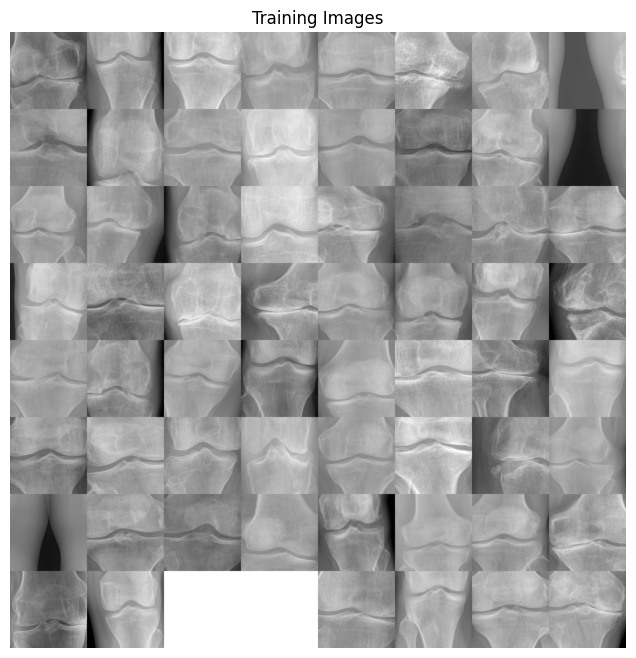

In [16]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))

In [17]:
# Verify dataloader is properly created
try:
    batch = next(iter(dataloader))  # Attempt to fetch a batch
    print("Dataloader is working properly.")
except NameError:
    print("Dataloader is not defined. Please check your dataset and dataloader initialization.")
except Exception as e:
    print("Error in dataloader:", e)


Dataloader is working properly.


Implementation
--------------






In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator and Discriminator Code

### Weights_initialize
Now, we can instantiate the generator and apply the `weights_init`
function. Check out the printed model to see how the generator object is
structured.


In [19]:
import torch
from torch import nn

# Batch size during training
batch_size = 192

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Base size of feature maps in generator
ngf = 16

# Base size of feature maps in discriminator
ndf = 16

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 64),
            nn.ReLU(True),
            # state size. (ngf*64) x 4 x 4
            nn.ConvTranspose2d(ngf * 64, ngf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            # state size. (ngf*32) x 8 x 8
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 16 x 16
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 32 x 32
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 64 x 64
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 128 x 128
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 256 x 256
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 512 x 512
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 512 x 512
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 256 x 256
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 128 x 128
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 64 x 64
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 32 x 32
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 16 x 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x 8 x 8
            nn.Conv2d(ndf * 32, ndf * 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*64) x 4 x 4
            nn.Conv2d(ndf * 64, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator(1)
netD = Discriminator(1)

inputG = torch.randn(batch_size, nz, 1, 1)
inputD = torch.randn(batch_size, nc, 512, 512)
#print(netG)
print(inputD.shape)
print("\nOutputs size:")
print(netG(inputG).size())
print(netD(inputD).size())

torch.Size([128, 3, 512, 512])

Outputs size:
torch.Size([128, 3, 512, 512])
torch.Size([128, 1, 1, 1])


In [20]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Loss Functions and Optimizers







In [21]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
# Verify dataloader is properly created
try:
    batch = next(iter(dataloader))  # Attempt to fetch a batch
    print("Dataloader is working properly.")
except NameError:
    print("Dataloader is not defined. Please check your dataset and dataloader initialization.")
except Exception as e:
    print("Error in dataloader:", e)


Dataloader is working properly.


# Training





In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        #print(epoch)

        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        #print(real_cpu.shape)

        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batc
        output=output.float()
        label =label.float()
        #print(output.shape)
        #print(label.shape)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #print(fake.detach())
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output,label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=0, normalize=True))

        iters += 1

Starting Training Loop...


 with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        
netG_load = torch.load( f'./model/GEN_{num_epochs}_{grade}.pth' )


Results
-------



**Loss versus training iteration**





In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**






In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# **Real Images vs. Fake Images**






In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
resol = "processed_512_"
#grade = 0
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title(f"Real Images{resol}{grade}")
img_real = np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0))
plt.imshow(img_real)
print(img_real.shape)

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title(f"Fake Images{resol}{grade}")
img_fake = np.transpose(img_list[-1],(1,2,0))
print(img_fake.shape)
plt.imshow(img_fake)

plt.tight_layout()
plt.savefig(f'GAN_image_knee_after{num_epochs}epoches{resol}{grade}{exp_date}.png')
plt.show()



In [ ]:

torch.save(netG, f'./model/GEN_{num_epochs}_{grade}{exp_date}.pth')
torch.save(netD, f'./model/Dis_{num_epochs}_{grade}{exp_date}.pth')

In [ ]:
arr = np.asarray(img_fake)
arr = np.split(arr, 8)
arr = np.array([np.split(x, 8, 1) for x in arr])
import scipy.misc
from PIL import Image
n=1
import matplotlib

for i in range(8):
    for j in range(8):
        print(i,j)
        img_array= arr[i][j]
        #print(img_array.shape)
        #im = Image.fromarray(img_array)
        matplotlib.image.imsave(f'./Proc_result/{exp_date}fake_image{n}.png', img_array)

        #im.save(f'./Proc_result/{grade}/fake_image{n}.png')
        #plt.show()
        #im = Image.fromarray(img_array)
        #im.save(f'./result/fake_image{n}.png')
        n +=1

In [ ]:
print(1)